# Generates Figures: Regional Timeseries

In [1]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')


In [2]:
# load transformed data
ds_djf_regional = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds_djf = ds_djf_regional[['SST', 'Chl_surf', 'KGP']]

#ds_djf_alt = ds_djf_regional[['SST', 'Chl_surf', 'KGP', 'NPP', 'Jint_100m_DIC']]
ds_djf

<xarray.Dataset>
Dimensions:    (length: 3, member_id: 34, region: 5, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * region     (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length     (length) float64 20.0 40.0 60.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Data variables:
    SST        (time, member_id, region) float64 dask.array<chunksize=(180, 34, 5), meta=np.ndarray>
    Chl_surf   (time, member_id, region) float64 dask.array<chunksize=(180, 34, 5), meta=np.ndarray>
    KGP        (time, length, member_id, region) float64 dask.array<chunksize=(90, 2, 34, 5), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [3]:
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
ds_ctrl_mean

<xarray.Dataset>
Dimensions:   (length: 3, region: 5)
Coordinates:
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length    (length) float64 20.0 40.0 60.0
Data variables:
    SST       (region) float64 4.782 4.31 4.44 4.408 4.782
    Chl_surf  (region) float64 0.7665 1.003 1.244 0.9447 0.7665
    KGP       (length, region) float64 0.02202 0.02735 ... -0.01663 -0.02046

Standard deviation of anomalies

In [4]:
ds_ctrl_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
ds_ctrl_std

<xarray.Dataset>
Dimensions:   (length: 3, region: 5)
Coordinates:
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length    (length) float64 20.0 40.0 60.0
Data variables:
    SST       (region) float64 0.1896 0.1848 0.2251 0.1817 0.1896
    Chl_surf  (region) float64 0.04342 0.09069 0.1197 0.08233 0.04342
    KGP       (length, region) float64 0.002902 0.003494 ... 0.002606 0.001869

## Compute the sign of the forced trend

In [5]:
%%time
ds_trend_sign = xr.where(
    ds_djf.sel(time=slice(2091, 2100)).mean(['time', 'member_id']) >= ds_ctrl_mean, 1., -1
).compute()
ds_trend_sign

CPU times: user 21.1 ms, sys: 4.78 ms, total: 25.9 ms
Wall time: 22.4 ms


<xarray.Dataset>
Dimensions:   (length: 3, region: 5)
Coordinates:
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length    (length) float64 20.0 40.0 60.0
Data variables:
    SST       (region) float64 1.0 1.0 1.0 1.0 1.0
    Chl_surf  (region) float64 -1.0 -1.0 -1.0 -1.0 -1.0
    KGP       (length, region) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 1.0

## Compute the value of the threshold for ToE

In [6]:
ds_toe_threshold = ds_ctrl_mean + 2. * ds_ctrl_std * ds_trend_sign
ds_toe_threshold

<xarray.Dataset>
Dimensions:   (length: 3, region: 5)
Coordinates:
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length    (length) float64 20.0 40.0 60.0
Data variables:
    SST       (region) float64 5.161 4.679 4.89 4.771 5.161
    Chl_surf  (region) float64 0.6797 0.8212 1.004 0.78 0.6797
    KGP       (length, region) float64 0.01621 0.02036 ... -0.02185 -0.01673

Quick plot

## Compute the time-evolving 2$\sigma$ timeseries

In [7]:
%%time
ds_2sigma = ds_djf.mean('member_id') #+ 2. * ds_trend_sign * ds_djf.std('member_id')
ds_2sigma = ds_2sigma.compute()
ds_2sigma

CPU times: user 12.3 ms, sys: 4.93 ms, total: 17.2 ms
Wall time: 11.6 ms


<xarray.Dataset>
Dimensions:   (length: 3, region: 5, time: 180)
Coordinates:
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length    (length) float64 20.0 40.0 60.0
Data variables:
    SST       (time, region) float64 4.751 4.325 4.476 ... 7.43 7.562 7.957
    Chl_surf  (time, region) float64 0.7613 1.02 1.262 ... 1.186 0.9082 0.6622
    KGP       (time, length, region) float64 0.02148 0.02671 ... -0.01529

In [8]:
%%time
ds_2sigma_neg = ds_djf.mean('member_id') - 2. * ds_trend_sign * ds_djf.std('member_id')
ds_2sigma_neg = ds_2sigma_neg.compute()
ds_2sigma_neg

CPU times: user 38.2 ms, sys: 7.11 ms, total: 45.3 ms
Wall time: 35.9 ms


<xarray.Dataset>
Dimensions:   (length: 3, region: 5, time: 180)
Coordinates:
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length    (length) float64 20.0 40.0 60.0
Data variables:
    SST       (time, region) float64 4.418 3.998 4.081 4.088 ... 7.0 7.141 7.666
    Chl_surf  (time, region) float64 0.8336 1.171 1.462 ... 1.375 1.062 0.762
    KGP       (time, length, region) float64 0.02727 0.03301 ... -0.01815

## Identify where the 2 sigma threshold has been crossed

In [9]:
%%time
ds_x_thresh = xr.where(ds_trend_sign > 0,
               ds_2sigma > ds_toe_threshold,
               ds_2sigma < ds_toe_threshold,               
               ).compute()
ds_x_thresh

CPU times: user 3.54 ms, sys: 673 µs, total: 4.21 ms
Wall time: 3.64 ms


<xarray.Dataset>
Dimensions:   (length: 3, region: 5, time: 180)
Coordinates:
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length    (length) float64 20.0 40.0 60.0
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
Data variables:
    SST       (region, time) bool False False False False ... True True True
    Chl_surf  (region, time) bool False False False False ... True True True
    KGP       (length, region, time) bool False False False ... True True True

In [10]:
import dask

In [11]:
%%time

@dask.delayed
def assess_toe(da_x_thresh):
    """Function to compute ToE from boolean threshold array"""
    if not any(da_x_thresh[:]):
        return da_x_thresh.time.data[-1]
    else:
        for l in range(len(da_x_thresh.time)):
             if all(da_x_thresh[l:]):
                return da_x_thresh.time.data[l]
        return da_x_thresh.time.data[-1]
    
ds_toe = xr.Dataset()
for v in ['SST', 'Chl_surf', 'KGP']:
    # stack lateral dims
    da = ds_x_thresh[v].stack(non_time_dims=[d for d in ds_x_thresh[v].dims if d != 'time'])
    
    # initialize temporary variable
    da_toe_stack = da.isel(time=0, drop=True)

    # loop over non time dims; compute ToE
    toe_results = []
    for i in range(len(da.non_time_dims)):
        toe_results.append(assess_toe(da[:, i]))        
    da_toe_stack.data = np.array(dask.compute(*toe_results)).astype(da.time.dtype)
    
    # assign to output dataset
    ds_toe[v] = da_toe_stack.unstack('non_time_dims')
    
ds_toe = ds_toe

ds_toe

CPU times: user 678 ms, sys: 10.6 ms, total: 688 ms
Wall time: 685 ms


<xarray.Dataset>
Dimensions:   (length: 3, region: 5)
Coordinates:
  * region    (region) object 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * length    (length) float64 20.0 40.0 60.0
Data variables:
    SST       (region) int64 2007 2007 2018 2007 2007
    Chl_surf  (region) int64 2091 2100 2100 2100 2091
    KGP       (length, region) int64 2078 2082 2093 2082 ... 2100 2100 2100 2090

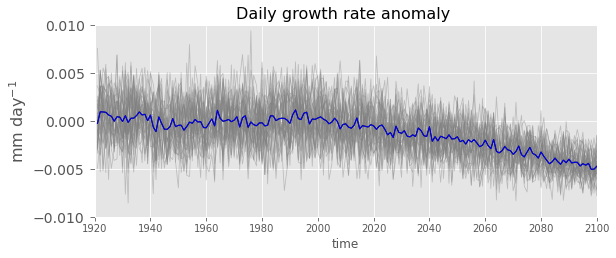

In [13]:
region = 'Southern Ocean'
v = ['KGP']
extra = 'solo'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.01
limYMax = 0.01

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
# ax.axhline(ds_ctrl_mean[v].sel(region=region, length = 40.)-ref, lw=1, color='k', linestyle='--',alpha = .25)
# ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) + 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
#            lw=1, color='r', linestyle='--')
# ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) - 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
#            lw=1, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b', lw=.5)#, marker='.')

# ax.plot(ds_toe[v].sel(region=region, length = 40.), 
#         ds_2sigma[v].sel(region=region, length = 40.).sel(time=ds_toe[v].sel(region=region, length = 40.))-ref, 
#         'r*', color= 'purple', markersize=15)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf_regional[v].long_name} anomaly ', fontsize = 16)

title = (f'{extra}-{region}-anomaly-EM')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + v + file, transparent=False, bbox_inches='tight')

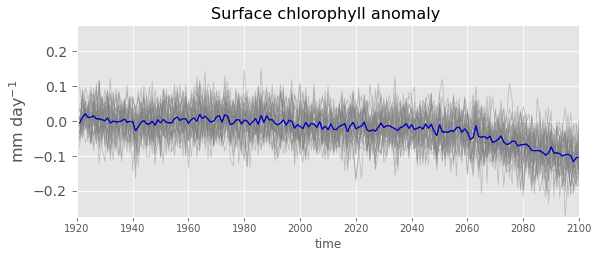

In [32]:
region = 'Southern Ocean'
extra = 'single'

v = 'Chl_surf'
limYMin = -0.275
limYMax = 0.275


#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
# ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
# ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
#            lw=1, color='r', linestyle='--')
# ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
#            lw=1, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b', lw=.5)#, marker='.')

# ax.plot(ds_toe[v].sel(region=region), 
#         ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
#         'r*', color= 'purple', markersize=15)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf_regional[v].long_name} anomaly ', fontsize = 16)

title = (f'{extra}-{region}-anomaly-EM')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + v + file, bbox_inches='tight')

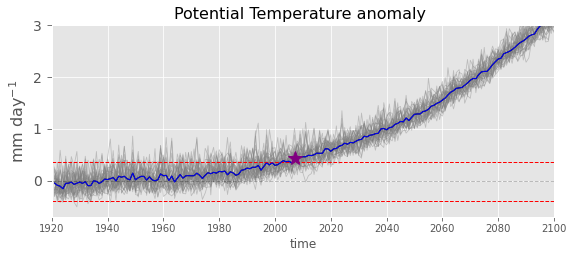

In [34]:
region = 'Southern Ocean'
extra = 'single-wTOE'

v = 'SST'
limYMin,limYMax = -0.7, 3

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b', lw=.5)#, marker='.')

ax.plot(ds_toe[v].sel(region=region), 
        ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
        'r*', color= 'purple', markersize=15)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf_regional[v].long_name} anomaly ', fontsize = 16)

title = (f'{extra}-{region}-anomaly-EM')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + v + file, bbox_inches='tight')

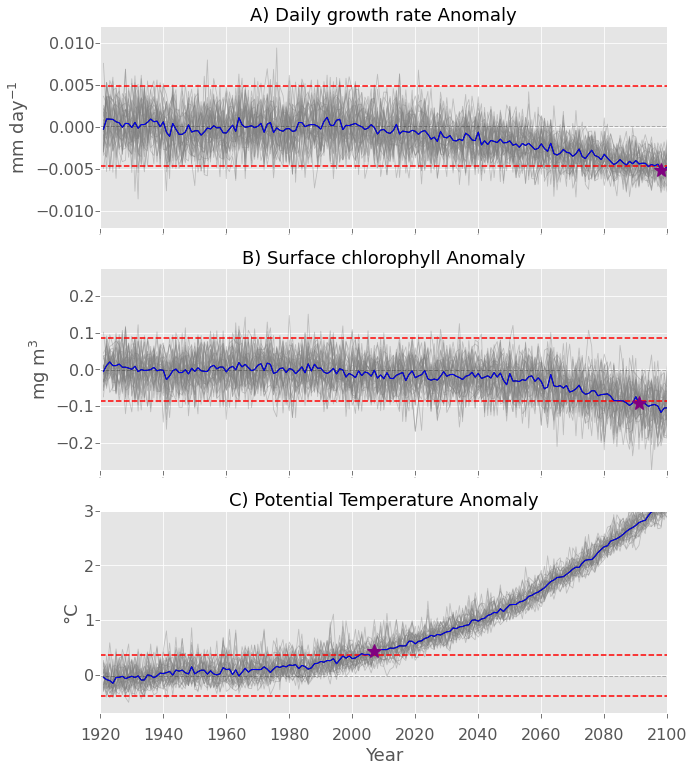

In [35]:
extra = 'TOE'
region = 'Southern Ocean'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.012
limYMax = 0.012
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region, length = 40.)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) + 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) - 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
           lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

ax.plot(ds_toe[v].sel(region=region, length = 40.), 
        ds_2sigma[v].sel(region=region, length = 40.).sel(time=ds_toe[v].sel(region=region, length = 40.))-ref, 
        color = 'purple', marker='*', markersize=15)

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)

ax.set_title(f'A) {ds_djf_regional[v].long_name} Anomaly', pad=5,fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)

v = 'Chl_surf'
limYMin = -0.275
limYMax = 0.275
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

ax.plot(ds_toe[v].sel(region=region), 
        ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
        color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)
ax.set_title(f'B) {ds_djf_regional[v].long_name} Anomaly', fontsize = 18, pad=5)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
limYMin,limYMax = -0.7, 3
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

ax.plot(ds_toe[v].sel(region=region), 
        ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
        color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major',length=5, pad=10, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'C) {ds_djf_regional[v].long_name} Anomaly', pad=5, fontsize = 18)
#####################################
gs.update(hspace=.2, top=.92, right =1)

title = (f'{extra}-{region}-anomaly-EM')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

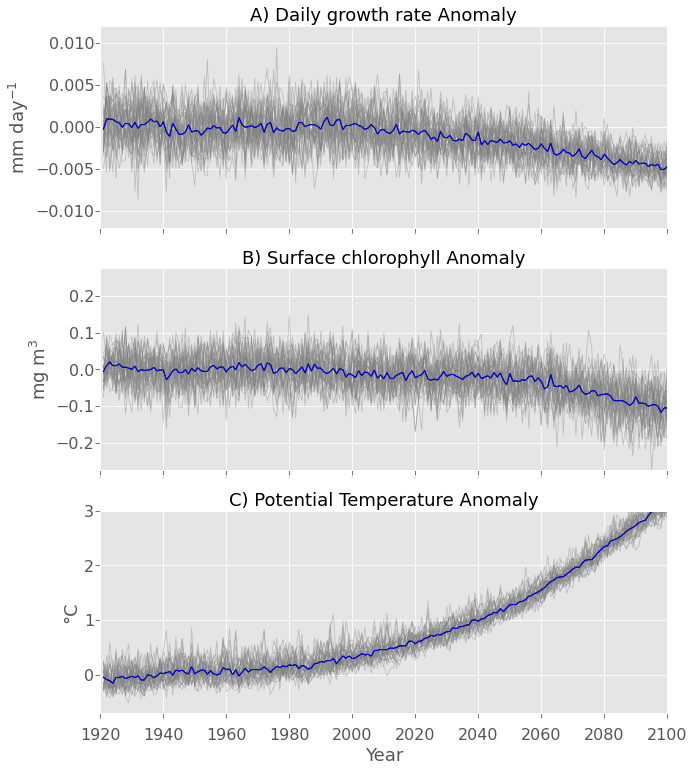

In [36]:
extra = 'solo'
region = 'Southern Ocean'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.012
limYMax = 0.012
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
# ax.axhline(ds_ctrl_mean[v].sel(region=region, length = 40.)-ref, lw=1, color='k', linestyle='--',alpha = .25)
# ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) + 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
#            lw=1.5, color='r', linestyle='--')
# ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) - 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
#            lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

# ax.plot(ds_toe[v].sel(region=region, length = 40.), 
#         ds_2sigma[v].sel(region=region, length = 40.).sel(time=ds_toe[v].sel(region=region, length = 40.))-ref, 
#         color = 'purple', marker='*', markersize=15)

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)

ax.set_title(f'A) {ds_djf_regional[v].long_name} Anomaly', pad=5,fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)

v = 'Chl_surf'
limYMin = -0.275
limYMax = 0.275
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
# ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
# ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
#            lw=1.5, color='r', linestyle='--')
# ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
#            lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

# ax.plot(ds_toe[v].sel(region=region), 
#         ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
#         color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)
ax.set_title(f'B) {ds_djf_regional[v].long_name} Anomaly', fontsize = 18, pad=5)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
limYMin,limYMax = -0.7, 3
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
# ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
# ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
#            lw=1.5, color='r', linestyle='--')
# ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
#            lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

# ax.plot(ds_toe[v].sel(region=region), 
#         ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
#         color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major',length=5, pad=10, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'C) {ds_djf_regional[v].long_name} Anomaly', pad=5, fontsize = 18)
#####################################
gs.update(hspace=.2, top=.92, right =1)

title = (f'{extra}-{region}-anomaly-EM')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

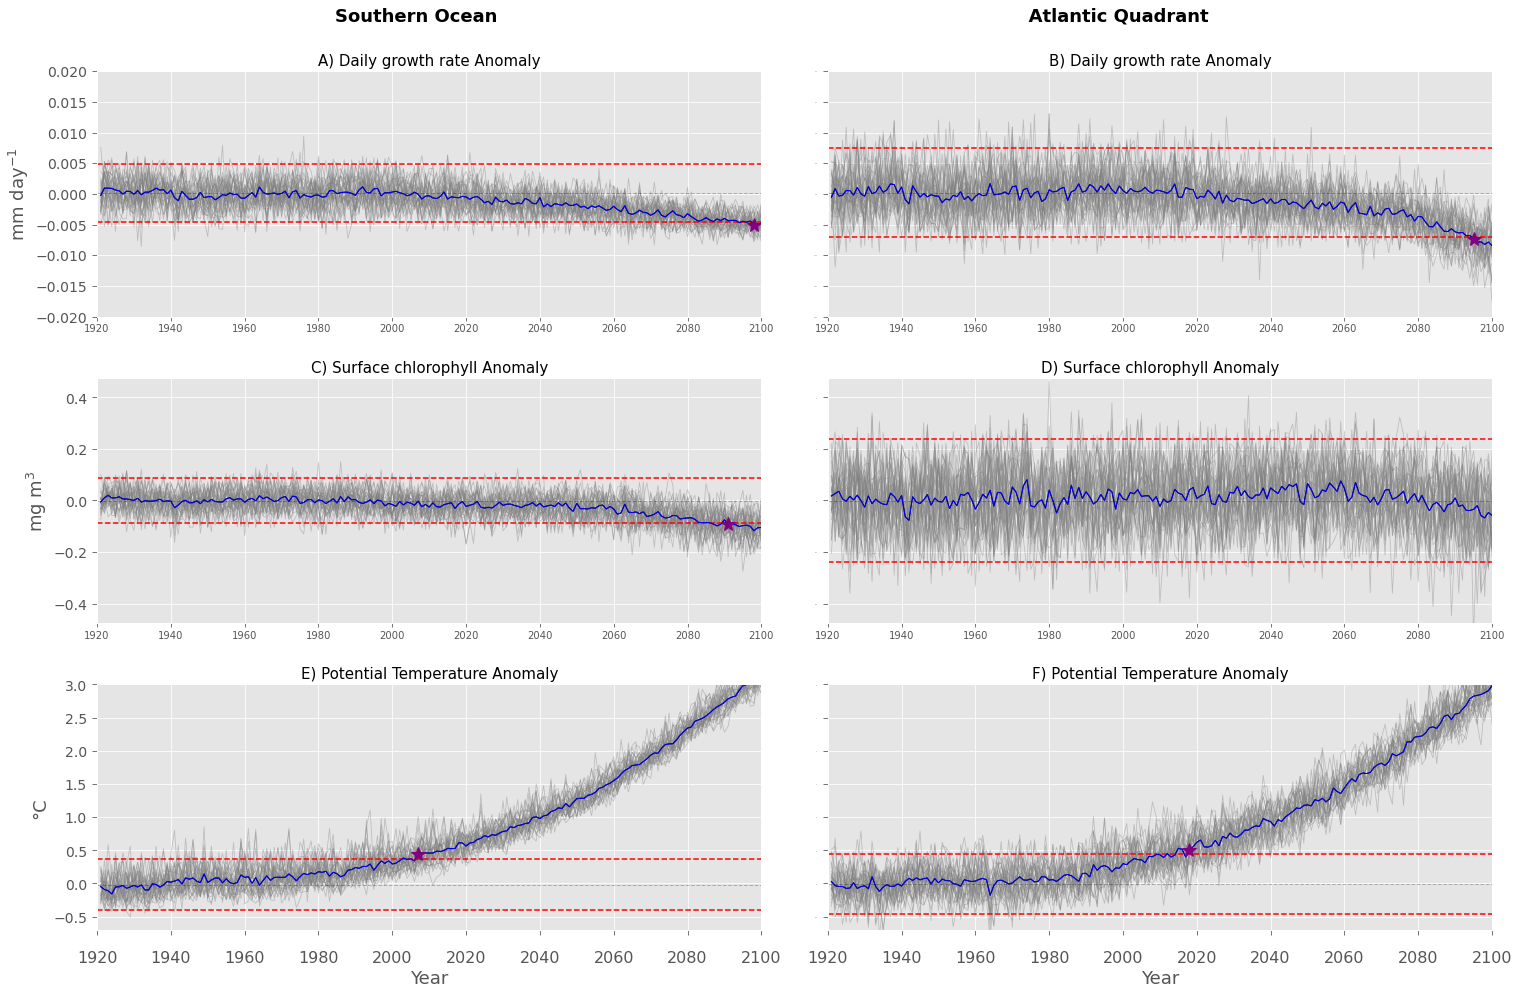

In [16]:
extra = 'TOE-Timeseries-Full'
region = 'Southern Ocean'

#####################################
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(3,2, width_ratios=[2,2])
plt.suptitle('Southern Ocean                                                                                     Atlantic Quadrant', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.02
limYMax = 0.02
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region, length = 40.)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) + 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) - 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
           lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

ax.plot(ds_toe[v].sel(region=region, length = 40.), 
        ds_2sigma[v].sel(region=region, length = 40.).sel(time=ds_toe[v].sel(region=region, length = 40.))-ref, 
        color = 'purple', marker='*', markersize=15)

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'A) {ds_djf_regional[v].long_name} Anomaly', fontsize = 15)
ax.set_xlabel(' ', fontsize = 2)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)

v = 'Chl_surf'
limYMin = -0.475
limYMax = 0.475
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

ax.plot(ds_toe[v].sel(region=region), 
        ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
        color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'C) {ds_djf_regional[v].long_name} Anomaly', fontsize = 15)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
limYMin,limYMax = -0.7, 3
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')

    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

ax.plot(ds_toe[v].sel(region=region), 
        ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
        color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.tick_params(axis='x', which='major',length=5, pad=15, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'E) {ds_djf_regional[v].long_name} Anomaly', fontsize = 15)
#####################################

region = 'Atlantic Quadrant'

#####################################
ax = fig.add_subplot(gs[0, 1])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.02
limYMax = 0.02
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)
ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region, length = 40.)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) + 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region, length = 40.)-ref) - 2 * ds_ctrl_std[v].sel(region=region, length = 40.), 
           lw=1.5, color='r', linestyle='--')
    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region, length = 40.)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

ax.plot(ds_toe[v].sel(region=region, length = 40.), 
        ds_2sigma[v].sel(region=region, length = 40.).sel(time=ds_toe[v].sel(region=region, length = 40.))-ref, 
        color = 'purple', marker='*', markersize=15)
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(' ', fontsize = .1)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=.1)
ax.set_title(f'B) {ds_djf_regional[v].long_name} Anomaly', fontsize = 15)
ax.set_xlabel(' ', fontsize = 2)

#####################################
ax = fig.add_subplot(gs[1, 1])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)

v = 'Chl_surf'
limYMin = -0.475
limYMax = 0.475
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)  
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)
ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')
    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

#ax.plot(ds_toe[v].sel(region=region), 
#        ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
#        color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(' ', fontsize = .1)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=.1)
ax.set_xlabel(' ', fontsize = 2)
ax.set_title(f'D) {ds_djf_regional[v].long_name} Anomaly', fontsize = 15)
#####################################
ax = fig.add_subplot(gs[2, 1])
ax.set_xlim((1920, 2100))

v = 'SST'
limYMin,limYMax = -0.7, 3
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')
# plot the control climate ± std
ax.axhline(ds_ctrl_mean[v].sel(region=region)-ref, lw=1, color='k', linestyle='--',alpha = .25)
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) + 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')
ax.axhline((ds_ctrl_mean[v].sel(region=region)-ref) - 2 * ds_ctrl_std[v].sel(region=region), 
           lw=1.5, color='r', linestyle='--')
    # highlight the threshold 
#ax.axhline((ds_toe_threshold[v].sel(region=region, length = 40.)-ref), lw=1, color='r')#, linestyle='--')
(ds_2sigma[v].sel(region=region)-ref).plot(ax=ax, color='b',lw=1)#, marker='.')
#(ds_2sigma_neg[v].sel(region=region)-ref).plot(ax=ax, color='b', lw=1)#, marker='.')

ax.plot(ds_toe[v].sel(region=region), 
        ds_2sigma[v].sel(region=region).sel(time=ds_toe[v].sel(region=region))-ref, 
        color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(' ', fontsize = .1)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=.1)
ax.tick_params(axis='x', which='major',length=5, pad=15, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'F) {ds_djf_regional[v].long_name} Anomaly', fontsize = 15)
#####################################
gs.update(wspace=0.1, hspace=0.25, top=.92)
#gs.update(hspace=.2, top=.92)
###############
title = (f'{extra}-anomaly-EM')
path = 'figures/'
file = '.png'
plt.savefig(path + title + file, bbox_inches='tight')

## UNCORRECTED:

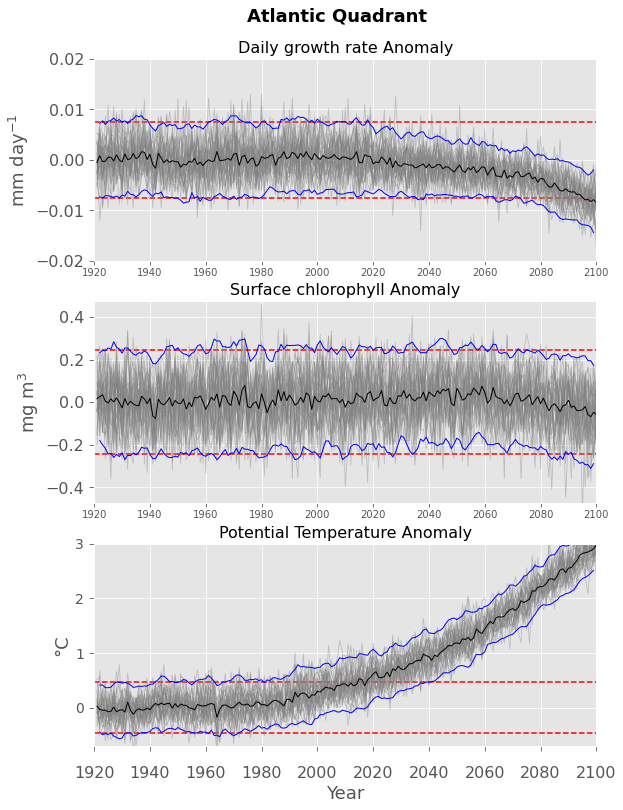

In [17]:
extra = 'TOE-uncorrected'
region = 'Atlantic Quadrant'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.02
limYMax = 0.02

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))

v = 'Chl_surf'
limYMin = -0.475
limYMax = 0.475
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
limYMin,limYMax = -0.7, 3
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.tick_params(axis='x', which='major',length=5, pad=15, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92)

title = (f'{extra}-{region}-anomaly')
path = 'figures/'
file = '.pdf'
#plt.savefig(path + title + file, bbox_inches='tight')

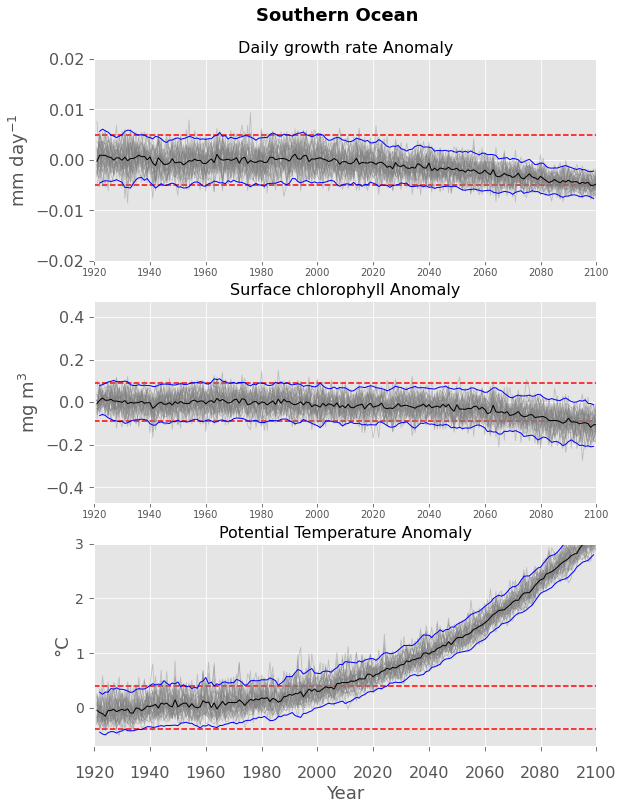

In [18]:
extra = 'TOE-uncorrected'
region = 'Southern Ocean'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.02
limYMax = 0.02

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))

v = 'Chl_surf'
limYMin = -0.475
limYMax = 0.475
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
limYMin,limYMax = -0.7, 3
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.tick_params(axis='x', which='major',length=5, pad=15, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92)

title = (f'{extra}-{region}-anomaly')
path = 'figures/'
file = '.pdf'
#plt.savefig(path + title + file, bbox_inches='tight')

In [19]:
for n, v in enumerate(variables):
    ax = axs[np.unravel_index(n, axs.shape)]
    
    # plot the ensemble
    for m_id in ds_djf.member_id.values:
        ds_djf[v].isel(nlat=j, nlon=i).sel(member_id=m_id).plot(ax=ax, color='gray', alpha=0.5)

    ds_djf[v].isel(nlat=j, nlon=i).mean('member_id').plot(ax=ax, color='k')
    
    # plot the control climate ± std
    ax.axhline(ds_ctrl_mean[v].isel(nlat=j, nlon=i), lw=1, color='k', linestyle='--')
    ax.axhline(ds_ctrl_mean[v].isel(nlat=j, nlon=i) + 2 * ds_ctrl_std[v].isel(nlat=j, nlon=i), 
               lw=1, color='r', linestyle='--')
    ax.axhline(ds_ctrl_mean[v].isel(nlat=j, nlon=i) - 2 * ds_ctrl_std[v].isel(nlat=j, nlon=i), 
               lw=1, color='r', linestyle='--')
    
    # highlight the threshold 
    ax.axhline(ds_toe_threshold[v].isel(nlat=j, nlon=i), 
               lw=3, color='r', linestyle='--',               
              )
    
    ds_2sigma[v].isel(nlat=j, nlon=i).plot(ax=ax, color='b', marker='.')
    
    ax.plot(
        ds_toe[v].isel(nlat=j, nlon=i), 
        ds_2sigma[v].isel(nlat=j, nlon=i).sel(time=ds_toe[v].isel(nlat=j, nlon=i)), 
        'r*', 
        markersize=15
    )
    ax.set_title(v)

NameError: name 'j' is not defined

In [ ]:
extra = 'TOE-uncorrected'
region = 'Atlantic Quadrant'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.02
limYMax = 0.02

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax


ds_2sigma[v].isel(nlat=j, nlon=i).plot(ax=ax, color='b', marker='.')


ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))

v = 'Chl_surf'
limYMin = -0.475
limYMax = 0.475
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
limYMin,limYMax = -0.7, 3
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.tick_params(axis='x', which='major',length=5, pad=15, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92)

title = (f'{extra}-{region}-anomaly')
path = 'figures/'
file = '.pdf'
#plt.savefig(path + title + file, bbox_inches='tight')

## CORRECTED:

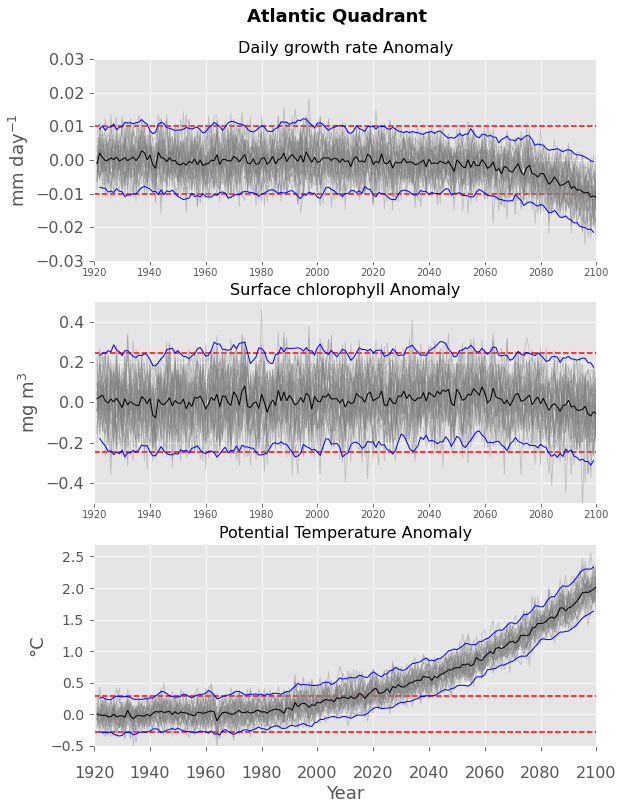

In [10]:
extra = 'TOE-corrected'
region = 'Atlantic Quadrant'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP_bias_corr'
limYMin = -0.03
limYMax = 0.03

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))

v = 'Chl_surf'
limYMin = -0.5
limYMax = 0.5
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST_bias_corr'
limYMin,limYMax = -0.5, 2.7
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.tick_params(axis='x', which='major',length=5, pad=15, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92)

title = (f'{extra}-{region}-anomaly')
path = 'figures/'
file = '.pdf'
#plt.savefig(path + title + file, bbox_inches='tight')

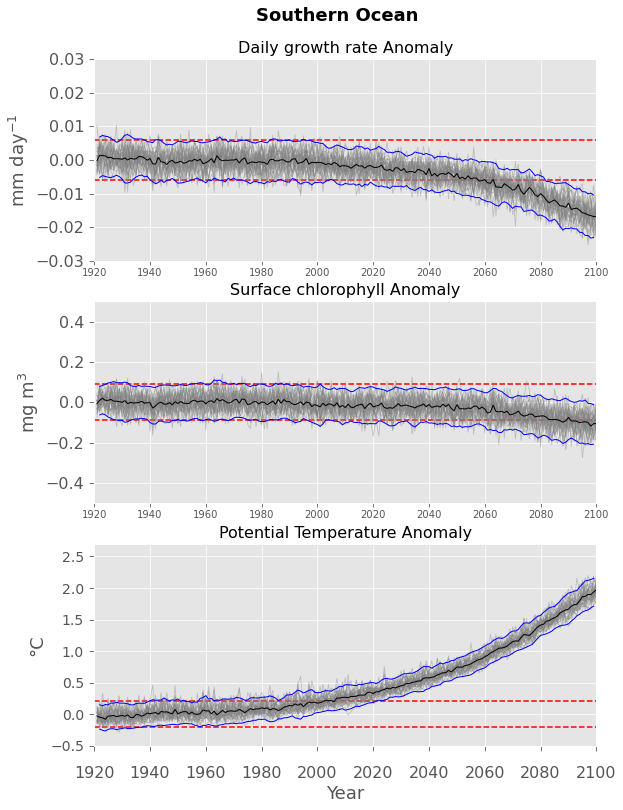

In [11]:
extra = 'TOE-corrected'
region = 'Southern Ocean'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP_bias_corr'
limYMin = -0.03
limYMax = 0.03

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))

v = 'Chl_surf'
limYMin = -0.5
limYMax = 0.5
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST_bias_corr'
limYMin,limYMax = -0.5, 2.7
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           2 * ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - 2 * y_std
y_hi = y_mean + 2 * y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.tick_params(axis='x', which='major',length=5, pad=15, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92)

title = (f'{extra}-{region}-anomaly')
path = 'figures/'
file = '.pdf'
#plt.savefig(path + title + file, bbox_inches='tight')

___

### silly 1 sigma look

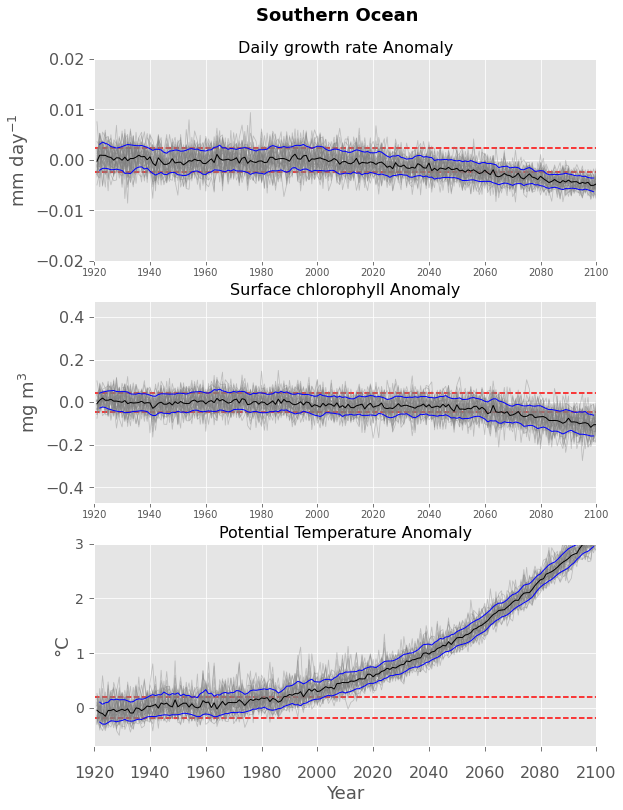

In [7]:
extra = 'TOE-uncorrected-1sig'
region = 'Southern Ocean'
plt.style.use('ggplot')

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

v = 'KGP'
limYMin = -0.02
limYMax = 0.02

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') +
           ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region, length = 40.).mean('member_id') -
           ds_djf_regional[v].sel(region=region, length = 40.).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region, length = 40.).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - y_std
y_hi = y_mean + y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax

ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))

v = 'Chl_surf'
limYMin = -0.475
limYMax = 0.475
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - y_std
y_hi = y_mean + y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=16)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
limYMin,limYMax = -0.7, 3
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf_regional.time,
        ds_djf_regional[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

y_upper = (ds_djf_regional[v].sel(region=region).mean('member_id') +
           ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()
y_lower = (ds_djf_regional[v].sel(region=region).mean('member_id') -
           ds_djf_regional[v].sel(region=region).std('member_id') -
           ref).rolling(time=3, center=True).mean()

ax.plot(ds_djf_regional.time, y_upper,
        '-', linewidth=1, color='b')
ax.plot(ds_djf_regional.time, y_lower,
        '-', linewidth=1, color='b')

y_mean = 0. #ref
y_std = ds_djf_regional[v].sel(region = region).sel(time=slice('1920', '1960')).std(['member_id', 'time'])
y_low = y_mean - y_std
y_hi = y_mean + y_std
s2n = y_mean / y_std

plt.hlines(y_low, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
plt.hlines(y_hi, 1920, 2100, color='r', linestyle = '--', label = 'max') #y,xmin,xmax
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.tick_params(axis='x', which='major',length=5, pad=15, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'{ds_djf_regional[v].long_name} Anomaly', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92)

title = (f'{extra}-{region}-anomaly')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')